In [ ]:
## standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import matplotlib.pyplot as plt
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data frame for input data
crimes = pd.read_csv('drive/MyDrive/DS8003 Project/data/Crimes_-_2001_to_Present.csv')

crimes.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,631,6.0,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"


In [ ]:
# convert dates to pandas datetime format
crimes.Date = pd.to_datetime(crimes.Date, format='%m/%d/%Y %I:%M:%S %p')
# setting the index to be the date will help us a lot later on
crimes.index = pd.DatetimeIndex(crimes.Date)

In [ ]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7404181 entries, 2015-09-05 13:30:00 to 2021-09-16 08:51:00
Data columns (total 22 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Case Number           object        
 2   Date                  datetime64[ns]
 3   Block                 object        
 4   IUCR                  object        
 5   Primary Type          object        
 6   Description           object        
 7   Location Description  object        
 8   Arrest                bool          
 9   Domestic              bool          
 10  Beat                  int64         
 11  District              float64       
 12  Ward                  float64       
 13  Community Area        float64       
 14  FBI Code              object        
 15  X Coordinate          float64       
 16  Y Coordinate          float64       
 17  Year                  int64         
 18  Updated O

In [ ]:
loc_to_change  = list(crimes['Location Description'].value_counts()[20:].index)
desc_to_change = list(crimes['Description'].value_counts()[20:].index)

crimes.loc[crimes['Location Description'].isin(loc_to_change) , crimes.columns=='Location Description'] = 'OTHER'
crimes.loc[crimes['Description'].isin(desc_to_change) , crimes.columns=='Description'] = 'OTHER'

In [ ]:
# we convert those 3 columns into 'Categorical' types
crimes['Primary Type']         = pd.Categorical(crimes['Primary Type'])
crimes['Location Description'] = pd.Categorical(crimes['Location Description'])
crimes['Description']          = pd.Categorical(crimes['Description'])

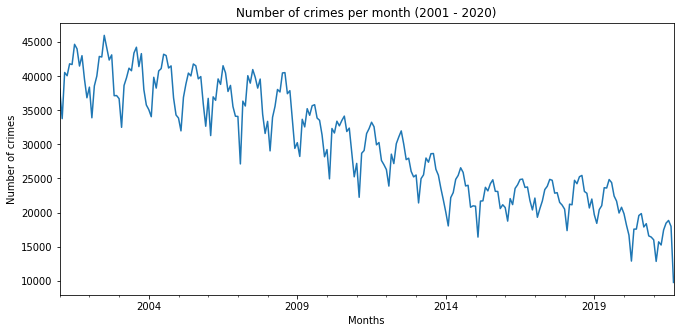

In [ ]:
plt.figure(figsize=(11,5))
crimes.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2001 - 2020)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

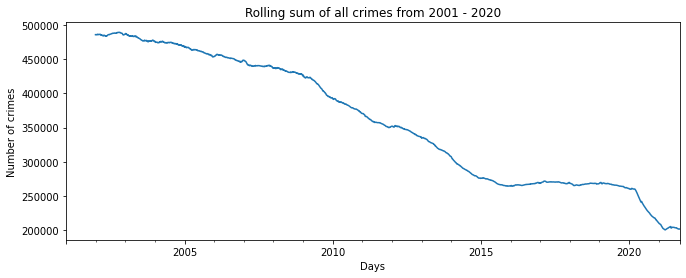

In [ ]:
plt.figure(figsize=(11,4))
crimes.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2001 - 2020')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

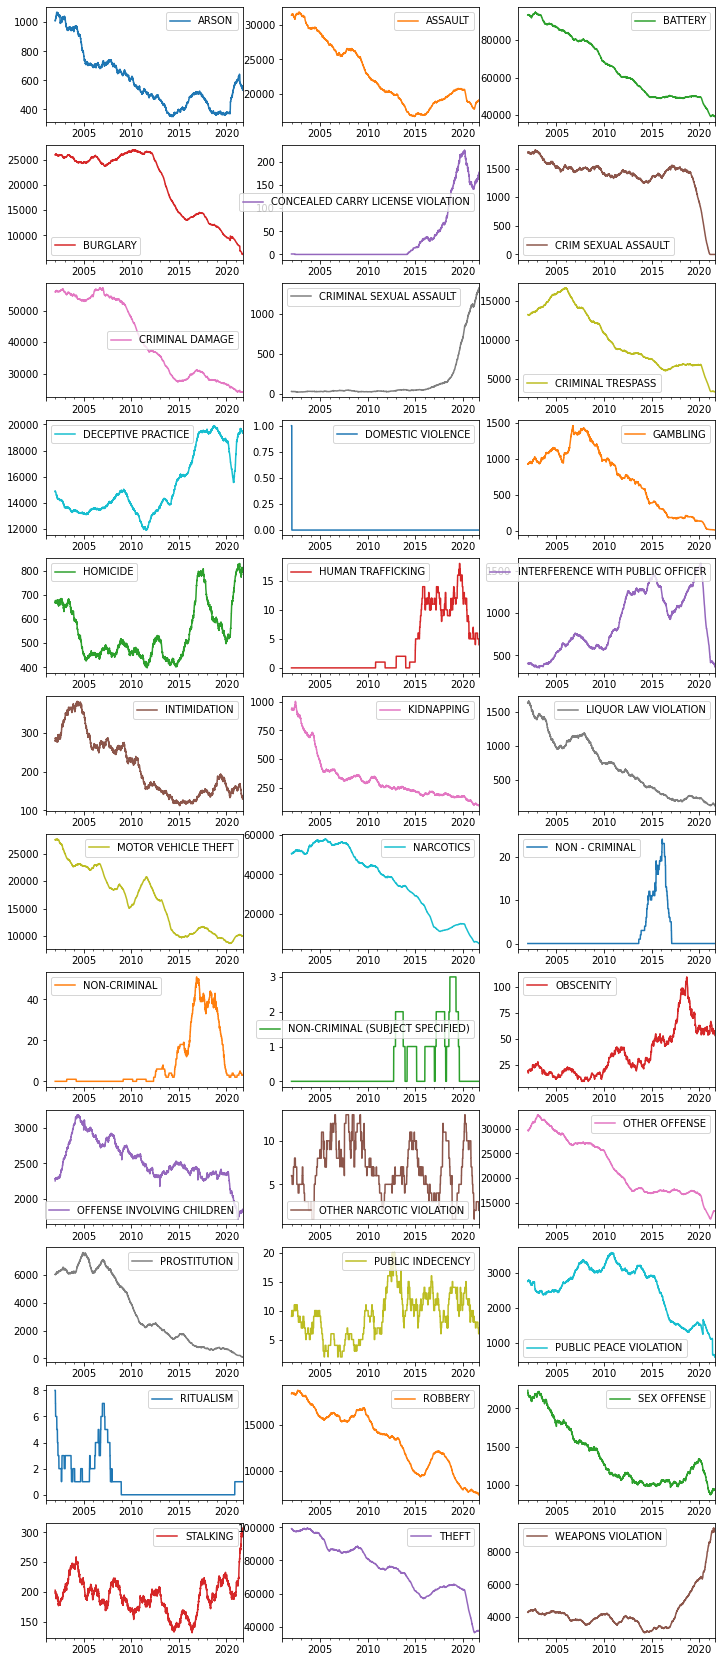

In [ ]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

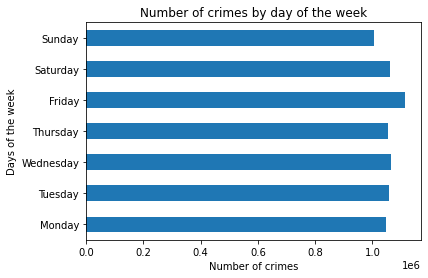

In [ ]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes.groupby([crimes.index.dayofweek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

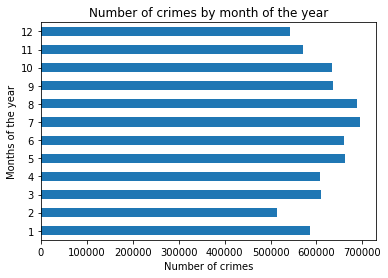

In [ ]:
crimes.groupby([crimes.index.month]).size().plot(kind='barh')
plt.ylabel('Months of the year')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by month of the year')
plt.show()

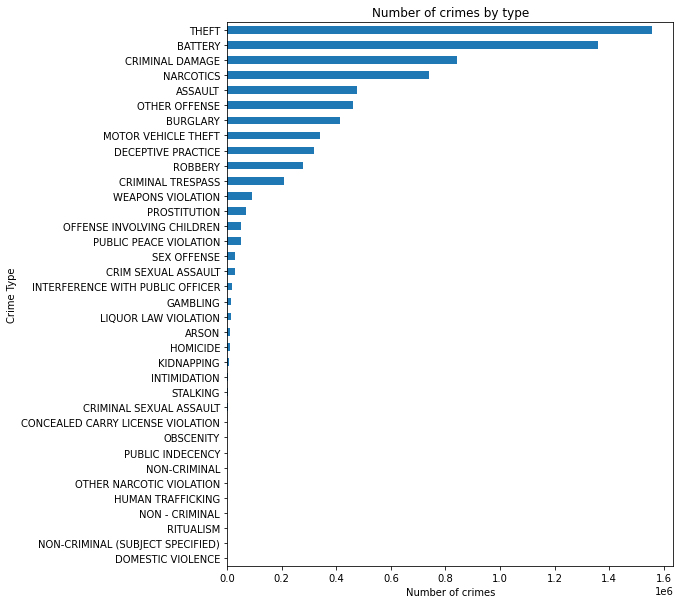

In [ ]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

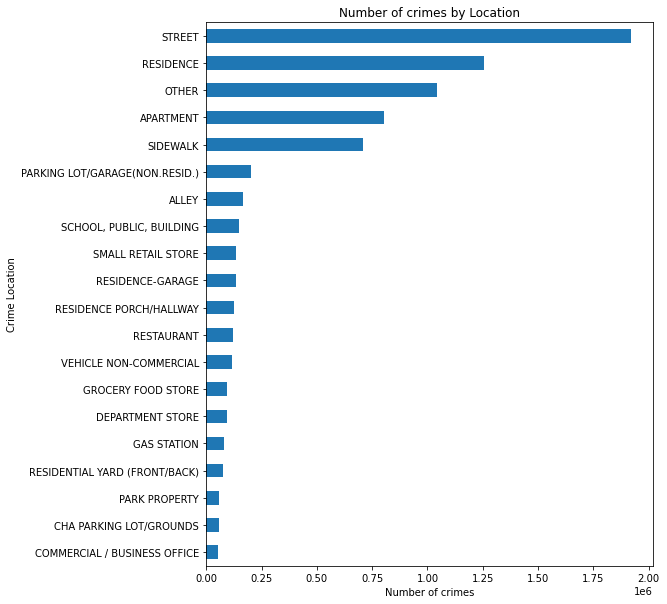

In [ ]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Location Description']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Location')
plt.ylabel('Crime Location')
plt.xlabel('Number of crimes')
plt.show()

In [ ]:
hour_by_location = crimes.pivot_table(values='ID', index='Location Description', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
hour_by_type     = crimes.pivot_table(values='ID', index='Primary Type', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
hour_by_week     = crimes.pivot_table(values='ID', index=crimes.index.hour, columns=crimes.index.day_name(), aggfunc=np.size).fillna(0)
hour_by_week     = hour_by_week[days].T # just reorder columns according to the the order of days
dayofweek_by_location = crimes.pivot_table(values='ID', index='Location Description', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
dayofweek_by_type = crimes.pivot_table(values='ID', index='Primary Type', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
location_by_type  = crimes.pivot_table(values='ID', index='Location Description', columns='Primary Type', aggfunc=np.size).fillna(0)

In [ ]:
from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled.values), np.abs(np.min(df_marginal_scaled.values))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)
    
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

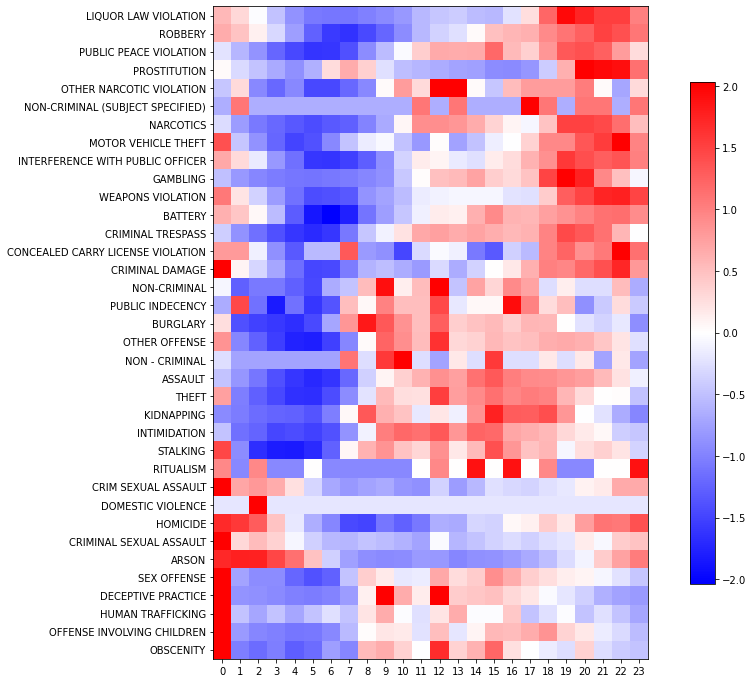

In [ ]:
plt.figure(figsize=(15,12))
scale_and_plot(hour_by_type)

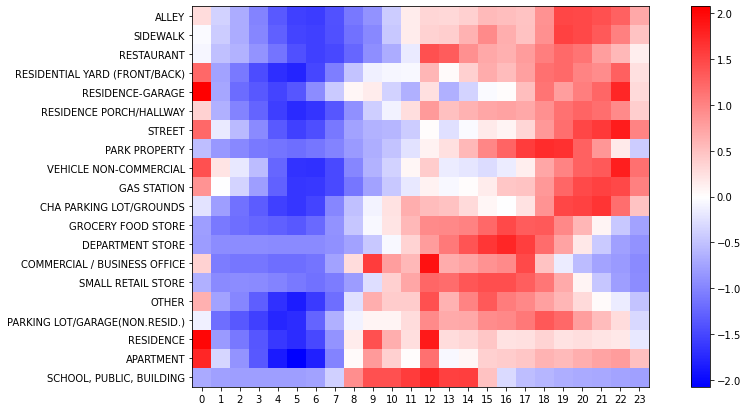

In [ ]:
plt.figure(figsize=(15,7))
scale_and_plot(hour_by_location)

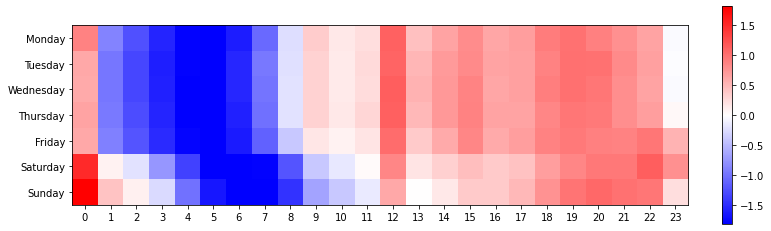

In [ ]:
plt.figure(figsize=(12,4))
scale_and_plot(hour_by_week, ix=np.arange(7))

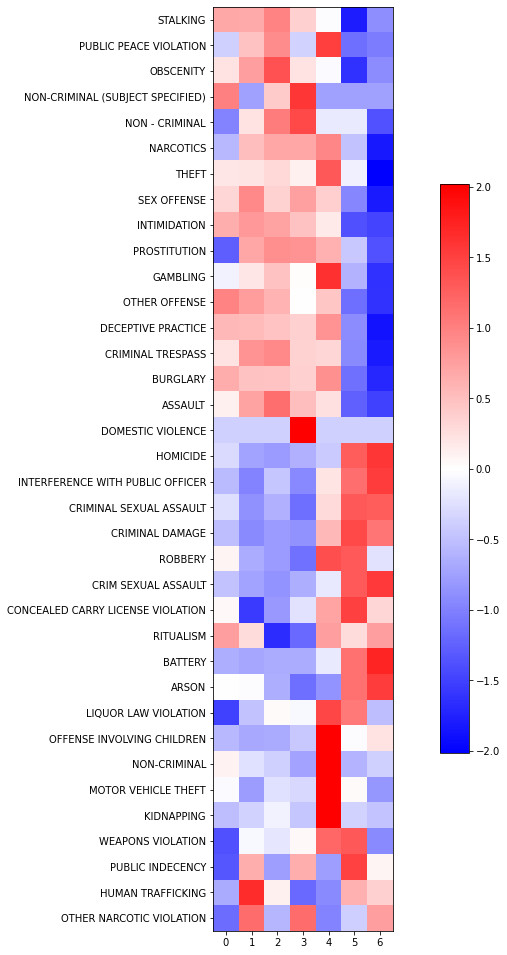

In [ ]:
plt.figure(figsize=(17,17))
scale_and_plot(dayofweek_by_type)

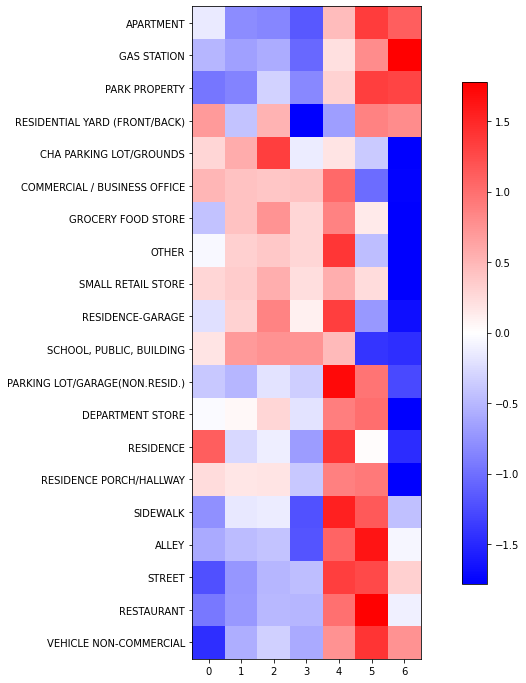

In [ ]:
plt.figure(figsize=(15,12))
scale_and_plot(dayofweek_by_location)

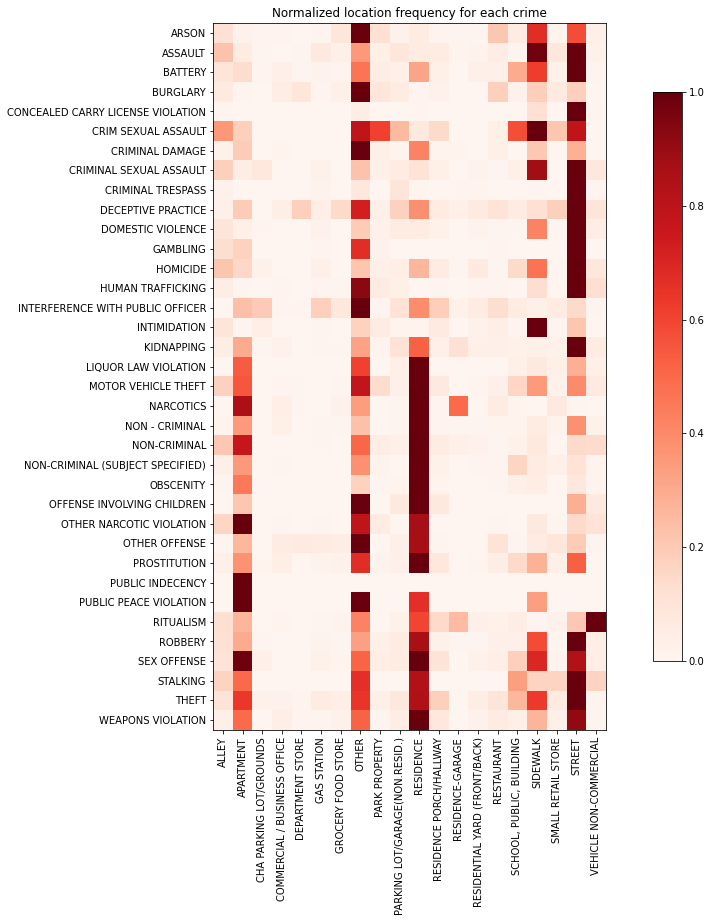

In [ ]:
df = normalize(location_by_type)
ix = AC(3).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()

In [ ]:
chicago_map = folium.Map(location=[41.864073,-87.706819], zoom_start=11, tiles="CartoDB dark_matter")

locations = crimes.groupby('Community Area').first()
new_locations = locations.loc[:, ['Latitude', 'Longitude', 'Location Description', 'Arrest']]

popup_text = """Community Index : {}<br
                Arrest : {}<br>
                Location Description : {}<br>"""

In [ ]:
for i in range(len(new_locations)):
    lat = new_locations.iloc[i][0]
    long = new_locations.iloc[i][1]
    popup_text = """Community Index : {}<br>
                Arrest : {}<br>
                Location Description : {}<br>"""
    popup_text = popup_text.format(new_locations.index[i],
                               new_locations.iloc[i][-1],
                               new_locations.iloc[i][-2]
                               )
    folium.CircleMarker(location = [lat, long], popup= popup_text, fill = True).add_to(chicago_map)

In [ ]:
chicago_map

In [ ]:
unique_locations = crimes['Location'].value_counts()

CR_index = pd.DataFrame({"Raw_String" : unique_locations.index, "ValueCount":unique_locations})
CR_index.index = range(len(unique_locations))
CR_index.head()

,Raw_String,ValueCount
0,"(41.976290414, -87.905227221)",13807
1,"(41.754592961, -87.741528537)",9972
2,"(41.883500187, -87.627876698)",7893
3,"(41.897895128, -87.624096605)",4798
4,"(41.896888586, -87.628203192)",3328


In [ ]:
def Location_extractor(Raw_Str):
    preProcess = Raw_Str[1:-1].split(',')
    lat =  float(preProcess[0])
    long = float(preProcess[1])
    return (lat, long)

In [ ]:
CR_index['LocationCoord'] = CR_index['Raw_String'].apply(Location_extractor)
CR_index  = CR_index.drop(columns=['Raw_String'], axis = 1)

In [ ]:
chicago_map_crime = folium.Map(location=[41.895140898, -87.624255632],
                        zoom_start=13,
                        tiles="CartoDB dark_matter")

for i in range(500):
    lat = CR_index['LocationCoord'].iloc[i][0]
    long = CR_index['LocationCoord'].iloc[i][1]
    radius = CR_index['ValueCount'].iloc[i] / 45
    
    if CR_index['ValueCount'].iloc[i] > 1000:
        color = "#FF4500"
    else:
        color = "#008080"
    
    popup_text = """Latitude : {}<br>
                Longitude : {}<br>
                Criminal Incidents : {}<br>"""
    popup_text = popup_text.format(lat,
                               long,
                               CR_index['ValueCount'].iloc[i]
                               )
    folium.CircleMarker(location = [lat, long], popup= popup_text,radius = radius, color = color, fill = True).add_to(chicago_map_crime)

In [ ]:
chicago_map_crime

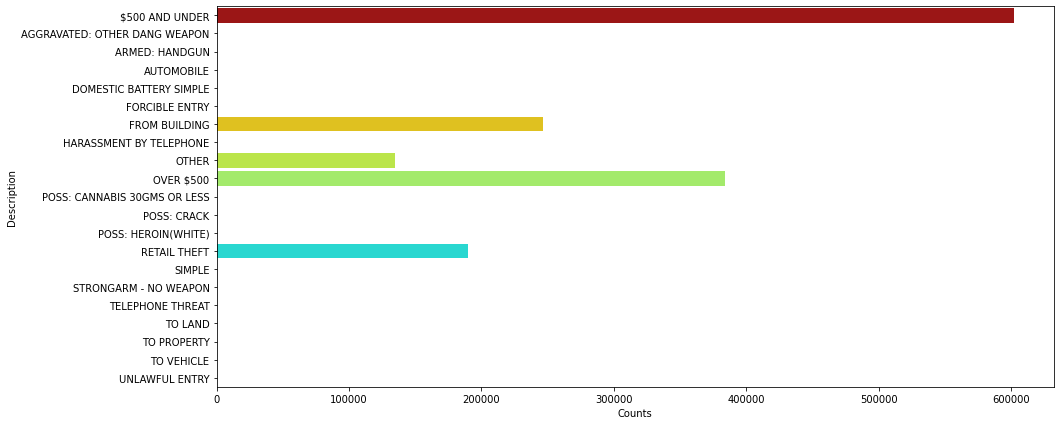

In [ ]:
# A closer look at thefts
df_theft = crimes[crimes['Primary Type'] == 'THEFT']
df_theft_data = pd.DataFrame({"Counts": df_theft['Description'].value_counts(), "Description" : df_theft['Description'].value_counts().index})
df_theft_data.reset_index(inplace=True)

df_theft_data = df_theft_data.drop(columns=['index'], axis = 1)

plt.figure(figsize = (15, 7))
sns.barplot(y ="Description", x = "Counts", data = df_theft_data.sort_values(by='Counts'), palette="jet_r")

In [ ]:
def plot_location_count_map(df, col):

  unique_locations = df['Location'].value_counts()
  PB_index = pd.DataFrame({"Raw_String" : unique_locations.index, "ValueCount":unique_locations})
  PB_index.index = range(len(unique_locations))

  PB_index['LocationCoord'] = PB_index['Raw_String'].apply(Location_extractor)
  PB_index  = PB_index.drop(columns=['Raw_String'], axis = 1)

  map = folium.Map(location=[41.895140898, -87.624255632], zoom_start=13)
  for i in range(500):
    lat = PB_index['LocationCoord'].iloc[i][0]
    long = PB_index['LocationCoord'].iloc[i][1]
    radius = PB_index['ValueCount'].iloc[i] / 3
    
    if PB_index['ValueCount'].iloc[i] > 30:
        color = "#FF4500"
    else:
        color = "#008080"
    
    popup_text = """Latitude : {}<br>
                Longitude : {}<br>
                {} : {}<br>"""
    popup_text = popup_text.format(lat,
                               long,
                               col,
                               PB_index['ValueCount'].iloc[i]
                               )
    folium.CircleMarker(location = [lat, long], popup= popup_text,radius = radius, color = color, fill = True).add_to(map)

  folium.TileLayer('cartodbpositron').add_to(map) 

  return map

In [ ]:
map = plot_location_count_map(crimes[crimes['Primary Type'] == 'ROBBERY'], 'Robberies')
map

In [ ]:
map = plot_location_count_map(crimes[crimes['Primary Type'] == 'PUBLIC PEACE VIOLATION'], 'Peace Violations')
map